<center>
    <h4>Smart Rescue System using UAVs and Object Detection</h4>
    <h6>Team Evolvers</h6>
</center>
<p style="text-align:right">github.com/bnsganesh</p>

### 1. Importing Packages

In [1]:
# pip install opencv-python

import cv2

# pip install matplotlib

import matplotlib.pyplot as plt

### 2. Loading and Configuring the Model

In [2]:
# Loading the Files
config_file = 'ssd_mobilenet_v3_large_coco_2020_01_14.pbtxt'
frozen_model = 'frozen_inference_graph.pb'

# Load the Model
model = cv2.dnn_DetectionModel(frozen_model, config_file)

# Load the Labels
classLabels = []
file_name = 'labels.txt'
with open(file_name,'rt') as fpt:
    classLabels = fpt.read().rstrip('\n').split('\n')

#print(classLabels)

# Config the Model
model.setInputSize(320,320)
model.setInputScale(1.0/127.5)
model.setInputMean(127.5)
model.setInputSwapRB(True)

<dnn_Model 000001AC1C5F9E10>

### 3. Image

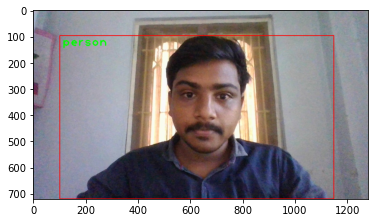

In [3]:
# Load the Image
img = cv2.imread('sample_person.jpg')

# COnvert to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# plt.imshow(img)

ClassIndex, confidence, bbox = model.detect(img,confThreshold=0.5)

# print(ClassIndex)

font_scale = 3
font = cv2.FONT_HERSHEY_PLAIN

for ClassInd, conf, boxes in zip(ClassIndex.flatten(), confidence.flatten(), bbox):
    cv2.rectangle(img,boxes,(255,0,0),2)
    cv2.putText(img,classLabels[ClassInd-1],(boxes[0]+10, boxes[1]+40),font, fontScale=font_scale, color=(0,255,0), thickness=3)

plt.imshow(img) # Show the Image

### 4. Video

In [4]:
# Load the Video
cap = cv2.VideoCapture(1)

# Check if the video is opened Correctly
if not cap.isOpened():
    cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open the Video")

# Detection frame by frame
while True:
    ret, frame = cap.read()
    
    ClassIndex, confidence, bbox = model.detect(frame,confThreshold=0.55)
    # print(ClassIndex)
    
    if(len(ClassIndex)!=0):
        for ClassInd, conf, boxes in zip(ClassIndex.flatten(), confidence.flatten(), bbox):
            if(ClassInd<=80):
                cv2.rectangle(frame,boxes,(255,0,0),2)
                cv2.putText(frame,classLabels[ClassInd-1],(boxes[0]+10, boxes[1]+40),font, fontScale=font_scale, color=(0,255,0), thickness=3)
    
    cv2.imshow('Object Detection',frame)
    if cv2.waitKey(2) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

#### SRS sends the Co-ordinates of the trapped people in the Flooded region.

We need to implement the following:
<ol>
    <li>Web API</li>
    <li>GSM</li>
    <li>Alert the Ground</li>
    <li>Detection</li>
</ol>

### Let's Implement !

#### 1. Web API
Sending Data to CloudChip for Visualisation

In [ ]:
# Packages Required

import paho.mqtt.client as mqtt
import json

def sendApi(latitude,longitude):
    
    TOKEN = 'KX39TCoUhW3nWbevoZ9w'  # Token to Access
    topic = 'v1/devices/me/telemetry' # Telementary
    qos=1

    client = mqtt.Client()
    client.username_pw_set(TOKEN)
    client.connect("www.cloudchip.io", 1883, 60)
    client.loop_start()

    # Data or Parameters to Send to Api
    data = {'latitude': latitude,'longitude': longitude}

    client.publish(topic, json.dumps(data), qos)
    client.loop_stop()
    client.disconnect()

#### 2. GSM
Sending SMS to Mobile

In [ ]:
# Packages Required

import serial
import RPi.GPIO as GPIO

def sendMessage(latitude,longitude):
    
    GPIO.setmode(GPIO.BOARD)    
    
    # Enable Serial Communication
    port = serial.Serial("/dev/ttyAMA0", baudrate=9600, timeout=1)
     
    # Transmitting AT Commands to the Modem ('\r\n' indicates the Enter key)
     
    port.write('AT'+'\r\n')     
    port.write('ATE0'+'\r\n')      # Disable the Echo
    port.write('AT+CMGF=1'+'\r\n')  # Select Message format as Text mode 
    port.write('AT+CNMI=2,1,0,0,0'+'\r\n')   # New SMS Message Indication
    port.write('AT+CMGS="9052191523"'+'\r\n')   # Sending a message to a particular Number
    port.write('-Person, Detected at Lat: '+latitude+', Long:'+longitude+'\r\n')  # Message: latitude and longitude
    port.write("\x1A") # Enable to send SMS

#### 3. Alert the Ground
Retreving Longitude and Latitude from the GPS Module

In [ ]:
# Packages required 
import serial

def decode(coord):
    x = coord.split(".")        #Converts DDDMM.MMMMM > DD deg MM.MMMMM min
    head = x[0]
    tail = x[1]
    deg = head[0:-2]
    min = head[-2:]
    return deg + " deg " + min + "." + tail + " min"

def parseGPS(data):
    sdata = data.split(",")
    latitude = decode(sdata[3]) # latitude
    longitude = decode(sdata[5]) # longitute
    sendMessage(latitude,longitude) # Sending SMS
    sendApi(latitude,longitude) # Sending Data to Api
 
def trigger():
    '''port = "/dev/serial0"
    ser = serial.Serial(port, baudrate = 9600, timeout = 0.5)
    parseGPS(data,person) # Access GPS lat, long  then sends to mobile and Api'''
    sendApi(16.190546,81.136154)

#### 4. Detection
Retrieving the count of the People, in the Fame

In [5]:
# Load the Video
cap = cv2.VideoCapture(1)

# Check if the video is opened Correctly
if not cap.isOpened():
    cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open the Video")

# Detection frame by frame
while True:
    ret, frame = cap.read()
    
    ClassIndex, confidence, bbox = model.detect(frame,confThreshold=0.55)
    # print(ClassIndex)
    
    if(len(ClassIndex)!=0):
        for ClassInd, conf, boxes in zip(ClassIndex.flatten(), confidence.flatten(), bbox):
            if(ClassInd<=80):
                cv2.rectangle(frame,boxes,(255,0,0),2)
                cv2.putText(frame,classLabels[ClassInd-1],(boxes[0]+10, boxes[1]+40),font, fontScale=font_scale, color=(0,255,0), thickness=3)
    
    cv2.imshow('Object Detection',frame)
    if cv2.waitKey(2) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()